In [ ]:
import pandas as pd

# Read the two parts of the visit data
visit_report_1 = pd.read_excel('Reporting_Visits_1.xlsx')
visit_report_2 = pd.read_excel('Reporting_Visits_2.xlsx')

# Concatenate the DataFrames
visit_report = pd.concat([visit_report_1, visit_report_2], ignore_index=True)

# Remove duplicate rows by concatenating all columns into a string
visit_report['_concat'] = visit_report.astype(str).agg('|'.join, axis=1)
visit_report = visit_report.drop_duplicates(subset=['_concat'])
visit_report = visit_report.drop(columns=['_concat'])

# Clean 'Site' column
visit_report['Site'] = visit_report['Site'].astype(str).str.strip()
visit_report = visit_report.dropna(subset=['Site'])  # Drop rows with missing site

# Convert datetime and calculate duration in minutes
visit_report['Dates'] = visit_report['InDateTime'].dt.strftime('%d/%m/%Y')
visit_report['Minutes'] = (visit_report['OutDateTime'] - visit_report['InDateTime']).dt.total_seconds() // 60
visit_report['Period'] = visit_report['InDateTime'].dt.strftime('%b-%Y')

# Create dwell time categories
bins = [-0.1, 5, 30, 60, 120, 180, 240, 300, 1440, float('inf')]
labels = ['0-5 minutes', '5-30 minutes', '30-60 minutes', '1-2 hours', '2-3 hours',
          '3-4 hours', '4-5 hours', '5+ hours', 'Over 24 hours']
visit_report['Dwell_Interval'] = pd.cut(visit_report['Minutes'], bins=bins, labels=labels)

# Create pivot table
pivot_table = visit_report.pivot_table(index='Site', columns='Dwell_Interval', values='Minutes', aggfunc='count', fill_value=0).reset_index()

# Calculate total per site
dwell_columns = pivot_table.columns.drop(['Site'])
pivot_table['Total'] = pivot_table[dwell_columns].sum(axis=1)

# Add grand total row
grand_total = pivot_table[dwell_columns].sum(numeric_only=True)
grand_total['Site'] = 'Grand Total'
grand_total['Total'] = grand_total[dwell_columns].sum()

# Append the total row
pivot_table = pd.concat([pivot_table, pd.DataFrame([grand_total])], ignore_index=True)

# Output the final table
#print(pivot_table)


/var/folders/vr/3ylp0mwj1c37m5vjr6slv2qc0000gn/T/ipykernel_48175/4053340700.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = visit_report.pivot_table(index='Site', columns='Dwell_Interval', values='Minutes', aggfunc='count', fill_value=0).reset_index()


In [3]:
import pandas as pd

# Read the original Excel file
excel_file = 'Reporting_Visits.xlsx'
df = pd.read_excel(excel_file)

# Determine the split index (halfway point)
split_index = len(df) // 2

# Split the DataFrame into two parts
df1 = df.iloc[:split_index]
df2 = df.iloc[split_index:]

# Save each part into a new Excel file
df1.to_excel('Reporting_Visits_1.xlsx', index=False)
df2.to_excel('Reporting_Visits_2.xlsx', index=False)

print("✅ Excel file split into 'Reporting_Visits_1.xlsx' and 'Reporting_Visits_2.xlsx'.")



✅ Excel file split into 'Reporting_Visits_1.xlsx' and 'Reporting_Visits_2.xlsx'.


In [76]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Step 1: Create 'Period' in 'mmm-yyyy' format
visit_report['Period'] = pd.to_datetime(visit_report['Dates']).dt.strftime('%b-%Y')

# Step 2: Create a datetime version for sorting
visit_report['Period_dt'] = pd.to_datetime(visit_report['Period'], format='%b-%Y')

# Step 3: Get unique sites
unique_sites = visit_report['Site'].unique()

# Step 4: Create pivot tables per site
pivot_tables_by_site = {}

for site in unique_sites:
    site_data = visit_report[visit_report['Site'] == site]
    pivot = site_data.pivot_table(index='Dwell_Interval', columns='Period_dt', values='Minutes', aggfunc='count', fill_value=0)
    
    # Convert datetime columns back to 'mmm-yyyy'
    pivot.columns = pivot.columns.strftime('%b-%Y')
    pivot_tables_by_site[site] = pivot

# Create a new workbook
wb = Workbook()

# Remove the default sheet
default_sheet = wb.active
wb.remove(default_sheet)

# Create one worksheet per site
for site, pivot_df in pivot_tables_by_site.items():
    # Create a sheet for the site (limit name to 31 characters and remove forbidden ones)
    sheet_name = site[:31].replace('/', '_').replace('\\', '_').replace('*', '_').replace('[', '_').replace(']', '_').replace(':', '_').replace('?', '_')
    ws = wb.create_sheet(title=sheet_name)

    # Write the pivot table to the new worksheet
    for r in dataframe_to_rows(pivot_df.reset_index(), index=False, header=True):
        ws.append(r)

# Save the workbook
wb.save("Visit_Report_PivotTables.xlsx")

/var/folders/vr/3ylp0mwj1c37m5vjr6slv2qc0000gn/T/ipykernel_48175/3094935807.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  visit_report['Period'] = pd.to_datetime(visit_report['Dates']).dt.strftime('%b-%Y')
/var/folders/vr/3ylp0mwj1c37m5vjr6slv2qc0000gn/T/ipykernel_48175/3094935807.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = site_data.pivot_table(index='Dwell_Interval', columns='Period_dt', values='Minutes', aggfunc='count', fill_value=0)
/var/folders/vr/3ylp0mwj1c37m5vjr6slv2qc0000gn/T/ipykernel_48175/3094935807.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this war

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os

# Load Excel file
file_path = "Visit_Report_PivotTables.xlsx"

# Read all sheets into a dictionary
all_sheets = pd.read_excel(file_path, sheet_name=None)

# List of intervals to plot
intervals = ['0-5 minutes', '5-30 minutes', '30-60 minutes', '1-2 hours',
             '2-3 hours', '3-4 hours', '4-5 hours', '5+ hours', 'Over 24 hours']

# Create output folder
output_folder = "Forecasts_2025"
os.makedirs(output_folder, exist_ok=True)

# Loop through each sheet (site)
for site_name, df in all_sheets.items():
    print(f"\n📊 Processing site: {site_name}")

    # Reformat: Dwell_Interval → columns, Months → index
    df_long = df.set_index("Dwell_Interval").T
    df_long.index = pd.to_datetime(df_long.index, format="%b-%Y")
    df_long.sort_index(inplace=True)

    # Prepare forecast index (12 months in 2025)
    forecast_index = pd.date_range(start="2025-01-01", periods=12, freq="MS")
    forecast_df = pd.DataFrame(index=forecast_index)

    # Apply SARIMA to each dwell interval
    for col in df_long.columns:
        series = df_long[col]

        try:
            model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                            enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=12)
            forecast_df[col] = forecast.round(0).astype(int)
        except Exception as e:
            print(f"⚠️ Could not forecast '{col}' in {site_name}: {e}")
            forecast_df[col] = None

    # Combine actual + forecast
    combined_df = pd.concat([df_long, forecast_df])
    combined_df.index.name = "Period"

    # Add 'Month_Name' and 'Year' columns
    combined_df["Month_Name"] = combined_df.index.month_name()
    combined_df["Year"] = combined_df.index.year


    # Replace negative values with 0 in those columns
    for interval in intervals:
        combined_df[interval] = combined_df[interval].clip(lower=0)

    # Save to Excel with site name in file
    clean_site = site_name.replace(" ", "_").replace(",", "")
    output_path = os.path.join(output_folder, f"{clean_site}_Forecast.xlsx")
    combined_df.to_excel(output_path)

    print(f"✅ Saved: {output_path}")



📊 Processing site: Gym Southampton Central
✅ Saved: Forecasts_2025/Gym_Southampton_Central_Forecast.xlsx

📊 Processing site: Gym London Stratford
✅ Saved: Forecasts_2025/Gym_London_Stratford_Forecast.xlsx

📊 Processing site: Gym Coventry Central


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters

✅ Saved: Forecasts_2025/Gym_Coventry_Central_Forecast.xlsx

📊 Processing site: Gym Sheffield, S10
✅ Saved: Forecasts_2025/Gym_Sheffield_S10_Forecast.xlsx

📊 Processing site: Gym Leicester
✅ Saved: Forecasts_2025/Gym_Leicester_Forecast.xlsx


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters

📊 Evaluation Metrics (Forecast vs. Actual 2024):
MAE:  3910.00
RMSE: 3910.00
MAPE: 45.39%


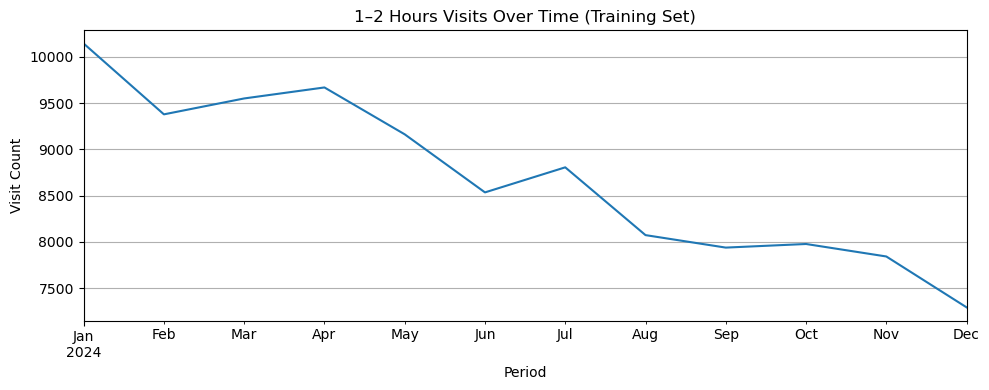

<Figure size 800x400 with 0 Axes>

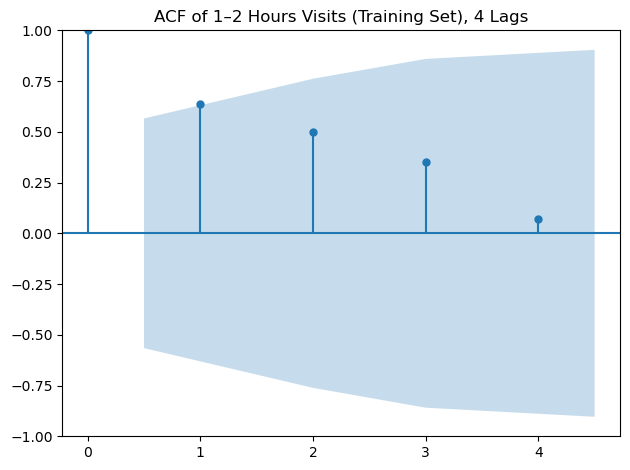

<Figure size 800x400 with 0 Axes>

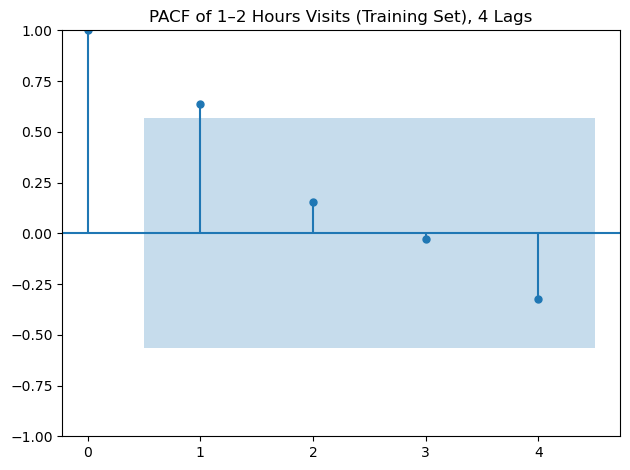

In [92]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load SARIMA output (actuals + forecasts)
df = pd.read_excel("Forecasts_2025/Gym_Leicester_Forecast.xlsx", parse_dates=["Period"])
df.set_index("Period", inplace=True)

# Extract actuals (2024) and forecasts (2025) for '1–2 hours'
actual = df[df["Year"] == 2024]["1-2 hours"].dropna().reset_index(drop=True)
forecast = df[df["Year"] == 2025]["1-2 hours"].dropna().reset_index(drop=True)

# Align both series
min_len = min(len(actual), len(forecast))
actual = actual[:min_len]
forecast = forecast[:min_len]

# Evaluation metrics
residuals = actual - forecast
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
mape = np.mean(np.abs(residuals / actual)) * 100

print("📊 Evaluation Metrics (Forecast vs. Actual 2024):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# ACF and PACF from training set (2024)
train_series = df[df["Year"] == 2024]["1-2 hours"].dropna()
safe_lags = min(10, len(train_series) // 3)

# Time series plot
plt.figure(figsize=(10, 4))
train_series.plot(title="1–2 Hours Visits Over Time (Training Set)")
plt.ylabel("Visit Count")
plt.xlabel("Period")
plt.grid(True)
plt.tight_layout()
plt.show()

# ACF plot
plt.figure(figsize=(8, 4))
plot_acf(train_series, lags=safe_lags)
plt.title(f"ACF of 1–2 Hours Visits (Training Set), {safe_lags} Lags")
plt.tight_layout()
plt.show()

# PACF plot
plt.figure(figsize=(8, 4))
plot_pacf(train_series, lags=safe_lags, method='ywm')
plt.title(f"PACF of 1–2 Hours Visits (Training Set), {safe_lags} Lags")
plt.tight_layout()
plt.show()


In [ ]:
from openpyxl.chart import BarChart, Reference
import calendar

# Paths
folder_path = '/Users/hugsneyf/Downloads/Term 8/Final Project/To be sent/DATA/Forecasts_2025'
output_file = os.path.join(folder_path, 'Forecasts_Summary_By_File.xlsx')

# Intervals to analyse
intervals = ['0-5 minutes', '5-30 minutes', '30-60 minutes', '1-2 hours',
             '2-3 hours', '3-4 hours', '4-5 hours', '5+ hours', 'Over 24 hours']

# Get all Excel files in the folder
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

# Start a new workbook
wb = Workbook()
default_sheet = wb.active
wb.remove(default_sheet)  # Remove default sheet

for file in excel_files:
    file_path = os.path.join(folder_path, file)
    sheet_name = os.path.splitext(file)[0][:31]  # Excel sheet name max length is 31
    ws = wb.create_sheet(title=sheet_name)
    current_row = 1

    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except Exception as e:
        continue

    # Try parsing the first column to datetime
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
    df = df.dropna(subset=[df.columns[0]])
    df.set_index(df.columns[0], inplace=True)

    if df.empty:
        print(f"⚠️ No valid datetime entries found in {file}, skipping...")
        continue

    # Filter by year
    df_2024 = df[df.index.year == 2024]
    df_2025 = df[df.index.year == 2025]

    for interval in intervals:
        if interval not in df.columns:
            continue  # Skip if not present

        # Monthly sums
        df_interval_2024 = df_2024[interval].groupby(df_2024.index.month).sum()
        df_interval_2025 = df_2025[interval].groupby(df_2025.index.month).sum()

        # Get month names from 1 to 12
        months = [calendar.month_name[m] for m in range(1, 13)]

        summary = pd.DataFrame({
            'Month': months,
            '2024': df_interval_2024.reindex(range(1, 13), fill_value=0).values,
            '2025': df_interval_2025.reindex(range(1, 13), fill_value=0).values
        })

        # Write interval title
        ws.cell(row=current_row, column=1, value=f"Interval: {interval}")
        current_row += 1

        # Write data
        for r in dataframe_to_rows(summary, index=False, header=True):
            for c_idx, value in enumerate(r, start=1):
                ws.cell(row=current_row, column=c_idx, value=value)
            current_row += 1

        # Add chart
        chart = BarChart()
        chart.title = f"Monthly Visits – {interval}"
        chart.x_axis.title = 'Month'
        chart.y_axis.title = 'Visits'

        # Correct range: include header row for titles
        chart_start_row = current_row - 13  # 12 months + 1 header
        chart_end_row = current_row - 1     # last data row

        data_ref = Reference(ws, min_col=2, max_col=3, min_row=chart_start_row, max_row=chart_end_row)
        cats_ref = Reference(ws, min_col=1, min_row=chart_start_row + 1, max_row=chart_end_row)  # Skip header for x-axis

        chart.add_data(data_ref, titles_from_data=True)
        chart.set_categories(cats_ref)
        ws.add_chart(chart, f"E{chart_start_row}")

        current_row += 2  # Add space before next block

# Save workbook
wb.save(output_file)
print("✅ Excel file created at:", output_file)


✅ Excel file created at: /Users/hugsneyf/Downloads/Term 8/Final Project/To be sent/DATA/Forecasts_2025/Forecasts_Summary_By_File.xlsx
